In [1]:
!pip install autogen-agentchat~=0.2 autogen psutil --quiet
# !pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental yfinance
!pip install -q langchain-openai langchain-anthropic termcolor langchain_community duckduckgo_search wikipedia openapi-python-client langgraph langchain_experimental openai --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mistral-common 1.5.2 requires pillow<11.0.0,>=10.3.0, but you have pillow 11.1.0 which is incompatible.
kfp 2.9.0 requires protobuf<5,>=4.21.1, but you have protobuf 5.29.3 which is incompatible.
kfp 2.9.0 requires requests-toolbelt<1,>=0.8.0, but you have requests-toolbelt 1.0.0 which is incompatible.
kfp-kubernetes 1.3.0 requires protobuf<5,>=4.21.1, but you have protobuf 5.29.3 which is incompatible.
kfp-pipeline-spec 0.4.0 requires protobuf<5,>=4.21.1, but you have protobuf 5.29.3 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 2.9.0 requires protobu

In [2]:
import os
import autogen
from typing import Literal

from pydantic import BaseModel, Field
from typing_extensions import Annotated

import autogen
from autogen.cache import Cache
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langgraph.graph import END, StateGraph, START

INFERENCE_SERVER_URL = "http://localhost:8000"
MODEL_NAME = "ibm-granite/granite-3.0-8b-instruct"
API_KEY= "alanliuxiang"


In [3]:
# Configuration for the vLLM endpoint
local_llm_config = {
    "config_list": [
        {
            "model": MODEL_NAME,
            "api_key": API_KEY,
            "base_url": f"{INFERENCE_SERVER_URL}/v1"
        }
    ],
    "cache_seed": None,
    "temperature": 0.01,
    "timeout": 600,
}

In [4]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

llm = ChatOpenAI(
    openai_api_key=API_KEY,
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

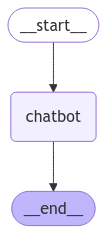

In [5]:
# Visualize your graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# response = graph.invoke("hello")
# print(response.content)

In [7]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  good


I'm glad to hear that! How can I assist you today?Assistant: I'm glad to hear that! How can I assist you today?


User:  


I'm trying to understand the concept of "data privacy" in the context of artificial intelligence (AI) and machine learning (ML). Can you explain it to me?

Absolutely, I'd be happy to help! Data privacy in AI and ML refers to the protection of personal data used in these technologies. Here are some key aspects:

1. **Data Collection**: AI and ML systems often require large amounts of data to function effectively. This data can include personal information, such as names, addresses, or browsing histories. It's crucial to ensure that this data is collected ethically and with proper consent.

2. **Data Storage**: Once collected, data must be stored securely to prevent unauthorized access. This includes both physical security (like locked servers) and digital security (like encryption).

3. **Data Usage**: AI and ML systems use data to learn and make decisions. However, it's important to ensure that this usage is transparent and respects user privacy. For example, if a system is using pers

User:  exit


Goodbye!


LangGraph for Beginners, Part 2: Call LLM.

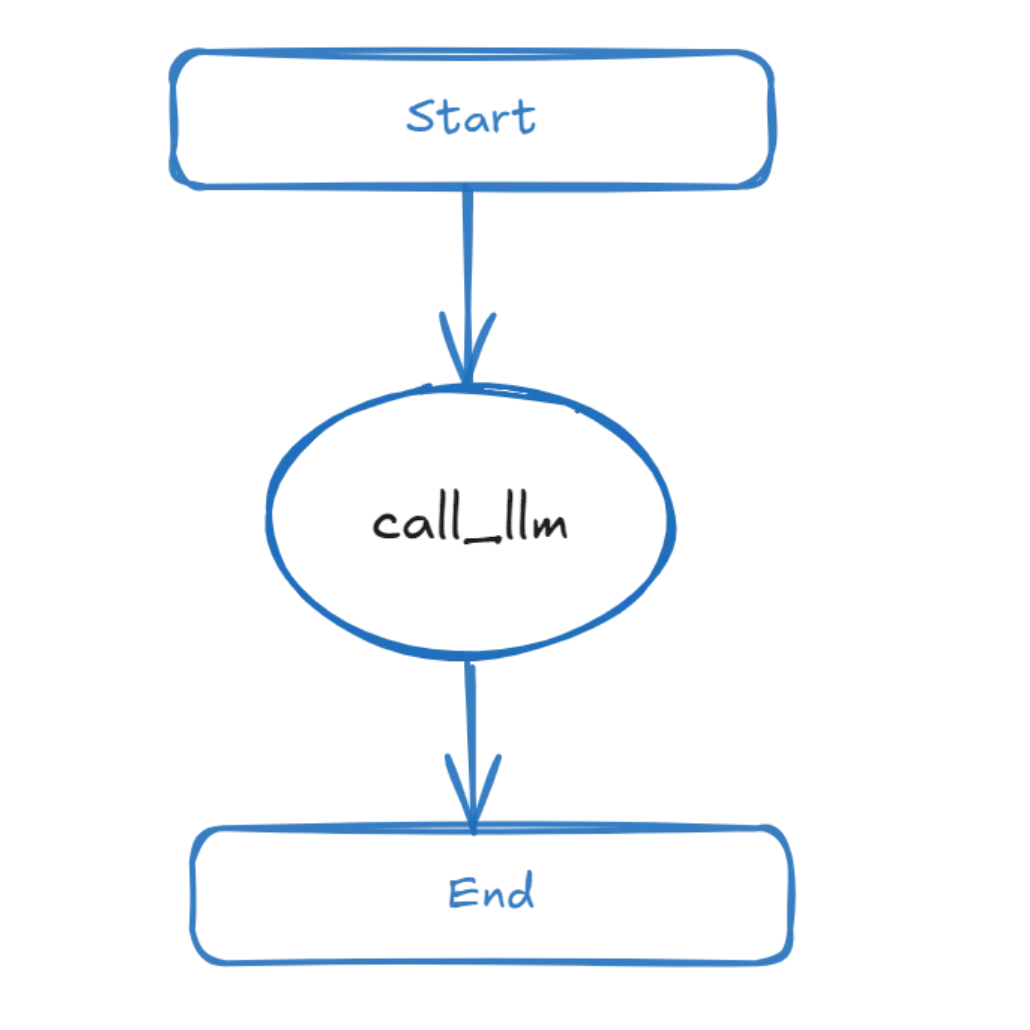

In [8]:
# define llm Node
def call_llm(message):
    return llm.invoke(message)

In [9]:
from langgraph.graph import Graph, START, END

# Create a new Graph
workflow = Graph()
# Add the nodes
workflow.add_node("call_llm", call_llm)

# Add the Edges
workflow.add_edge(START, "call_llm")
workflow.add_edge("call_llm", END)

#Compile the workflow
app = workflow.compile()

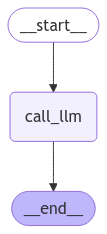

In [10]:
# Visualize your graph
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
response = app.invoke("hello")
print(response.content)

Hello! How can I assist you today?Hello! How can I assist you today?
